In [ ]:
import pandas as pd

# Load the dataset
file_path = "dataset.csv"
df = pd.read_csv(file_path)

# Show basic information
df_info = df.info()
df_head = df.head()
df_description = df.describe(include='all')

df_info, df_head, df_description


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18368 entries, 0 to 18367
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      18368 non-null  int64  
 1   SystemCodeNumber        18368 non-null  object 
 2   Capacity                18368 non-null  int64  
 3   Latitude                18368 non-null  float64
 4   Longitude               18368 non-null  float64
 5   Occupancy               18368 non-null  int64  
 6   VehicleType             18368 non-null  object 
 7   TrafficConditionNearby  18368 non-null  object 
 8   QueueLength             18368 non-null  int64  
 9   IsSpecialDay            18368 non-null  int64  
 10  LastUpdatedDate         18368 non-null  object 
 11  LastUpdatedTime         18368 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 1.7+ MB


(None,
    ID SystemCodeNumber  Capacity   Latitude  Longitude  Occupancy VehicleType  \
 0   0      BHMBCCMKT01       577  26.144536  91.736172         61         car   
 1   1      BHMBCCMKT01       577  26.144536  91.736172         64         car   
 2   2      BHMBCCMKT01       577  26.144536  91.736172         80         car   
 3   3      BHMBCCMKT01       577  26.144536  91.736172        107         car   
 4   4      BHMBCCMKT01       577  26.144536  91.736172        150        bike   
 
   TrafficConditionNearby  QueueLength  IsSpecialDay LastUpdatedDate  \
 0                    low            1             0      04-10-2016   
 1                    low            1             0      04-10-2016   
 2                    low            2             0      04-10-2016   
 3                    low            2             0      04-10-2016   
 4                    low            2             0      04-10-2016   
 
   LastUpdatedTime  
 0        07:59:00  
 1        08:25:00  
 2

In [ ]:
import numpy as np

# Make a copy of the dataset for preprocessing
df_processed = df.copy()

# Step 1: Combine date and time into a single timestamp
df_processed['timestamp'] = pd.to_datetime(df_processed['LastUpdatedDate'] + ' ' + df_processed['LastUpdatedTime'],
                                           format='%d-%m-%Y %H:%M:%S')

# Step 2: Encode categorical features
# Encode VehicleType (car:1, bike:0.5, truck:1.5, NA:1.0 as default)
vehicle_weights = {'car': 1.0, 'bike': 0.5, 'truck': 1.5}
df_processed['VehicleTypeWeight'] = df_processed['VehicleType'].map(vehicle_weights).fillna(1.0)

# Encode TrafficConditionNearby (low:1, medium:2, high:3)
traffic_levels = {'low': 1, 'medium': 2, 'high': 3}
df_processed['TrafficLevel'] = df_processed['TrafficConditionNearby'].map(traffic_levels).fillna(2)

# Step 3: Normalize Occupancy by Capacity
df_processed['OccupancyRate'] = df_processed['Occupancy'] / df_processed['Capacity']

# Step 4: Sort by timestamp within each parking lot
df_processed = df_processed.sort_values(by=['SystemCodeNumber', 'timestamp']).reset_index(drop=True)

# Step 5: Initialize pricing
# We start with a base price of $10 for each lot and update it over time
alpha = 2.0
base_price = 10.0

# Group by each lot and calculate Model 1 pricing
def model_1_pricing(group):
    prices = [base_price]
    for t in range(1, len(group)):
        prev_price = prices[-1]
        occupancy_rate = group.iloc[t]['OccupancyRate']
        new_price = prev_price + alpha * occupancy_rate
        # Clip the price between 5 and 20
        new_price = np.clip(new_price, 5, 20)
        prices.append(new_price)
    group['Model1Price'] = prices
    return group

df_model1 = df_processed.groupby('SystemCodeNumber', group_keys=False).apply(model_1_pricing)

# Show the first few rows with calculated prices
df_model1[['SystemCodeNumber', 'timestamp', 'Occupancy', 'Capacity', 'OccupancyRate', 'Model1Price']].head(10)


/tmp/ipython-input-2-1212541595.py:43: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_model1 = df_processed.groupby('SystemCodeNumber', group_keys=False).apply(model_1_pricing)


,SystemCodeNumber,timestamp,Occupancy,Capacity,OccupancyRate,Model1Price
0,BHMBCCMKT01,2016-10-04 07:59:00,61,577,0.105719,10.000000
1,BHMBCCMKT01,2016-10-04 08:25:00,64,577,0.110919,10.221837
2,BHMBCCMKT01,2016-10-04 08:59:00,80,577,0.138648,10.499133
3,BHMBCCMKT01,2016-10-04 09:32:00,107,577,0.185442,10.870017
4,BHMBCCMKT01,2016-10-04 09:59:00,150,577,0.259965,11.389948
5,BHMBCCMKT01,2016-10-04 10:26:00,177,577,0.306759,12.003466
6,BHMBCCMKT01,2016-10-04 10:59:00,219,577,0.379549,12.762565
7,BHMBCCMKT01,2016-10-04 11:25:00,247,577,0.428076,13.618718
8,BHMBCCMKT01,2016-10-04 11:59:00,259,577,0.448873,14.516464
9,BHMBCCMKT01,2016-10-04 12:29:00,266,577,0.461005,15.438475


Model 2 Implementation:

Training to find the optimal values of alpha,beta,delta ...

In [ ]:
# For each row, compute RawDemand
# Then shift Occupancy by -1 (next time step's true target)



In [ ]:
import pandas as pd
import numpy as np

# Load the dataset
df_model2 = pd.read_csv("dataset.csv")  # Ensure your dataset is in the same directory

# Step 1: Timestamp creation
df_model2['timestamp'] = pd.to_datetime(df_model2['LastUpdatedDate'] + ' ' + df_model2['LastUpdatedTime'],
                                 format='%d-%m-%Y %H:%M:%S')

# Step 2: Feature Encoding
vehicle_weights = {'car': 1.0, 'bike': 0.5, 'truck': 1.5}
df_model2['VehicleTypeWeight'] = df_model2['VehicleType'].map(vehicle_weights).fillna(1.0)

traffic_levels = {'low': 1, 'medium': 2, 'high': 3}
df_model2['TrafficLevel'] = df_model2['TrafficConditionNearby'].map(traffic_levels).fillna(2)

# Step 3: Feature Engineering
df_model2['OccupancyRate'] = df_model2['Occupancy'] / df_model2['Capacity']

# Step 4: Sort by time for temporal consistency
df_model2 = df_model2.sort_values(by=['SystemCodeNumber', 'timestamp']).reset_index(drop=True)

# Calculate FutureOccupancy *before* dropping NAs
df_model2['FutureOccupancy'] = df_model2.groupby('SystemCodeNumber')['Occupancy'].shift(-1)

# Drop NA values *after* feature engineering and calculating FutureOccupancy
df_model2.dropna(subset=['FutureOccupancy'], inplace=True)

# Linear regression fit
from sklearn.linear_model import LinearRegression

X = df_model2[['OccupancyRate', 'QueueLength', 'TrafficLevel', 'IsSpecialDay', 'VehicleTypeWeight']]
y = df_model2['FutureOccupancy']

model = LinearRegression()
model.fit(X, y)

# Now extract weights
alpha, beta, gamma, delta, epsilon = model.coef_
print(alpha, beta, gamma, delta, epsilon)
# # Step 5: Define weights for demand function
# alpha = 1.0     # Occupancy
# beta = 0.2      # Queue length
# gamma = 0.3     # Traffic (penalty)
# delta = 0.5     # Special day bonus
# epsilon = 0.4   # Vehicle type

# Step 6: Compute Raw Demand Score
df_model2['RawDemand'] = (
    alpha * df_model2['OccupancyRate'] +
    beta * df_model2['QueueLength'] -
    gamma * df_model2['TrafficLevel'] +
    delta * df_model2['IsSpecialDay'] +
    epsilon * df_model2['VehicleTypeWeight']
)

# Step 7: Normalize demand per parking lot
def normalize_demand(group):
    min_d = group['RawDemand'].min()
    max_d = group['RawDemand'].max()
    group['NormalizedDemand'] = (group['RawDemand'] - min_d) / (max_d - min_d + 1e-6)
    return group

df_model2 = df_model2.groupby('SystemCodeNumber', group_keys=False).apply(normalize_demand)

# Step 8: Price Calculation
base_price = 10.0
lmbda = 1.0  # sensitivity multiplier

df_model2['Model2Price'] = base_price * (1 + lmbda * df_model2['NormalizedDemand'])
df_model2['Model2Price'] = df_model2['Model2Price'].clip(lower=5.0, upper=20.0)  # bound prices

# Optional: preview
df_model2[['SystemCodeNumber', 'timestamp', 'OccupancyRate', 'QueueLength',
    'TrafficLevel', 'VehicleTypeWeight', 'IsSpecialDay',
    'NormalizedDemand', 'Model2Price']].head(10)

305.44698141825535 235.77224151007948 -579.4343411851738 -504.8491921870858 9.051560455503889


/tmp/ipython-input-4-3756330331.py:65: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_model2 = df_model2.groupby('SystemCodeNumber', group_keys=False).apply(normalize_demand)


,SystemCodeNumber,timestamp,OccupancyRate,QueueLength,TrafficLevel,VehicleTypeWeight,IsSpecialDay,NormalizedDemand,Model2Price
0,BHMBCCMKT01,2016-10-04 07:59:00,0.105719,1,1.0,1.0,0,0.194089,11.940894
1,BHMBCCMKT01,2016-10-04 08:25:00,0.110919,1,1.0,1.0,0,0.194486,11.944864
2,BHMBCCMKT01,2016-10-04 08:59:00,0.138648,2,1.0,1.0,0,0.255545,12.555452
3,BHMBCCMKT01,2016-10-04 09:32:00,0.185442,2,1.0,1.0,0,0.259118,12.591184
4,BHMBCCMKT01,2016-10-04 09:59:00,0.259965,2,1.0,0.5,0,0.263678,12.636775
5,BHMBCCMKT01,2016-10-04 10:26:00,0.306759,3,1.0,1.0,0,0.327323,13.273234
6,BHMBCCMKT01,2016-10-04 10:59:00,0.379549,6,3.0,1.5,0,0.800546,18.005460
7,BHMBCCMKT01,2016-10-04 11:25:00,0.428076,5,2.0,1.0,0,0.599324,15.993243
8,BHMBCCMKT01,2016-10-04 11:59:00,0.448873,5,2.0,1.0,0,0.600912,16.009124
9,BHMBCCMKT01,2016-10-04 12:29:00,0.461005,8,3.0,0.5,0,0.922386,19.223858


Checking if the newly learned weights are good or not

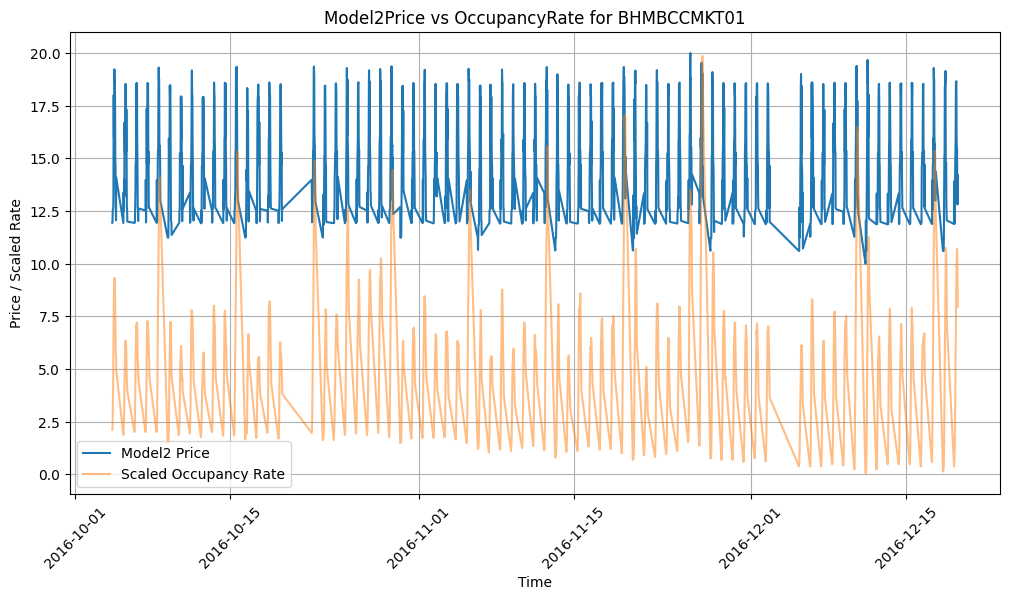

In [ ]:
import matplotlib.pyplot as plt

lot = 'BHMBCCMKT01'  # or any lot
df_lot = df_model2[df_model2['SystemCodeNumber'] == lot]

plt.figure(figsize=(12, 6))
plt.plot(df_lot['timestamp'], df_lot['Model2Price'], label='Model2 Price')
plt.plot(df_lot['timestamp'], df_lot['OccupancyRate'] * 20, label='Scaled Occupancy Rate', alpha=0.5)
plt.legend()
plt.title(f"Model2Price vs OccupancyRate for {lot}")
plt.xlabel("Time")
plt.ylabel("Price / Scaled Rate")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [ ]:
df_model1['Revenue_Model1'] = df_model1['Model1Price'] * df_model1['Occupancy']
df_model2['Revenue_Model2'] = df_model2['Model2Price'] * df_model2['Occupancy']

total1 = df_model1['Revenue_Model1'].sum()
total2 = df_model2['Revenue_Model2'].sum()

print("Model 1 Revenue:", round(total1, 2))
print("Model 2 Revenue:", round(total2, 2))

Model 1 Revenue: 268012669.5
Model 2 Revenue: 197458689.29


Model 3

In [ ]:
from math import radians, cos, sin, asin, sqrt
import pandas as pd
import numpy as np

# Extract unique parking lots
lots = df[['SystemCodeNumber', 'Latitude', 'Longitude']].drop_duplicates().reset_index(drop=True)

# Haversine formula
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # km
    dlat, dlon = radians(lat2-lat1), radians(lon2-lon1)
    a = sin(dlat/2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2)**2
    return 2 * R * asin(sqrt(a))

# Compute pairwise distances
distances = {}
for i, row_i in lots.iterrows():
    for j, row_j in lots.iterrows():
        if i != j:
            dist = haversine(row_i['Latitude'], row_i['Longitude'], row_j['Latitude'], row_j['Longitude'])
            distances[(row_i['SystemCodeNumber'], row_j['SystemCodeNumber'])] = dist

# Convert to DataFrame for quick lookup
distance_df = pd.DataFrame([
    {'LotA': k[0], 'LotB': k[1], 'DistanceKM': v}
    for k, v in distances.items()
])


In [ ]:
df_model3 = df.copy()
from math import radians, cos, sin, asin, sqrt
import pandas as pd
import numpy as np

# Step 1: Timestamp creation for df_model3
df_model3['timestamp'] = pd.to_datetime(df_model3['LastUpdatedDate'] + ' ' + df_model3['LastUpdatedTime'],
                                 format='%d-%m-%Y %H:%M:%S')

# Step 2: Feature Encoding (re-created for df_model3)
vehicle_weights = {'car': 1.0, 'bike': 0.5, 'truck': 1.5}
df_model3['VehicleTypeWeight'] = df_model3['VehicleType'].map(vehicle_weights).fillna(1.0)

traffic_levels = {'low': 1, 'medium': 2, 'high': 3}
df_model3['TrafficLevel'] = df_model3['TrafficConditionNearby'].map(traffic_levels).fillna(2)

# Step 3: Feature Engineering (re-created for df_model3)
df_model3['OccupancyRate'] = df_model3['Occupancy'] / df_model3['Capacity']


# Extract unique lots
lots = df_model3[['SystemCodeNumber', 'Latitude', 'Longitude']].drop_duplicates().reset_index(drop=True)

# Haversine distance function
def haversine(lat1, lon1, lat2, lon2):
    R = 6371
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat/2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2)**2
    return 2 * R * asin(sqrt(a))

# Compute pairwise distances
distances = {}
for i, row_i in lots.iterrows():
    for j, row_j in lots.iterrows():
        if i != j:
            dist = haversine(row_i['Latitude'], row_i['Longitude'], row_j['Latitude'], row_j['Longitude'])
            distances[(row_i['SystemCodeNumber'], row_j['SystemCodeNumber'])] = dist

distance_df = pd.DataFrame([
    {'LotA': k[0], 'LotB': k[1], 'DistanceKM': v}
    for k, v in distances.items()
])
# Nearby lots within 1 km
NEARBY_RADIUS_KM = 1.0

nearby_lots_dict = (
    distance_df[distance_df['DistanceKM'] <= NEARBY_RADIUS_KM]
    .groupby('LotA')['LotB']
    .apply(list)
    .to_dict()
)
# Ensure 'Model3Price' exists
if 'Model3Price' not in df_model3.columns:
    df_model3['Model3Price'] = 10.0

# Fast lookup for (lot, timestamp) → price
# price_lookup = df_model3.set_index(['SystemCodeNumber', 'timestamp'])['Model3Price'].to_dict()

# Function to compute average competitor price at same timestamp
def compute_competitor_price(row):
    lot = row['SystemCodeNumber']
    time = row['timestamp']
    nearby_lots = nearby_lots_dict.get(lot, [])
    # Use the price_lookup dictionary which will be created after Model3Price is calculated
    competitor_prices = [price_lookup.get((other_lot, time)) for other_lot in nearby_lots]
    competitor_prices = [p for p in competitor_prices if p is not None]
    return np.mean(competitor_prices) if competitor_prices else np.nan

# Recalculate Model3Price using damped incremental demand model (like Model 1 but smarter)
# df_model3 = df_model3.sort_values(by=['SystemCodeNumber', 'timestamp']).copy()

# Normalized demand (same as in Model 2)
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_model3['RawDemand'] = (
    1.0 * df_model3['OccupancyRate'] +
    0.2 * df_model3['QueueLength'] -
    0.3 * df_model3['TrafficLevel'] +
    0.5 * df_model3['IsSpecialDay'] +
    0.4 * df_model3['VehicleTypeWeight']
)

df_model3['NormalizedDemand'] = df_model3.groupby('SystemCodeNumber')['RawDemand'].transform(
    lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten()
)

# Dampen extreme demand
df_model3['NormalizedDemand'] = df_model3['NormalizedDemand'] ** 1.5

# Incremental Model3Price generation (base + demand growth - decay)
def generate_model3price(group, alpha=1.8, decay_factor=0.3):
    prices = [10.0]  # base price
    for t in range(1, len(group)):
        prev = prices[-1]
        demand = group.iloc[t]['NormalizedDemand']
        decay = decay_factor * (1 - demand)
        price = prev + alpha * demand - decay
        price = np.clip(price, 5.0, 20.0)
        prices.append(price)
    group['Model3Price'] = prices
    return group

df_model3 = df_model3.groupby('SystemCodeNumber', group_keys=False).apply(generate_model3price)

# Create price_lookup AFTER Model3Price is generated
price_lookup = df_model3.set_index(['SystemCodeNumber', 'timestamp'])['Model3Price'].to_dict()

# Apply competitive logic *after* generating base Model3Price and having OccupancyRate
df_model3['AvgCompetitorPrice'] = df_model3.apply(compute_competitor_price, axis=1)

# Example competitive logic
def adjust_price_or_reroute(row, threshold=0.95):
    occ = row['OccupancyRate']
    own_price = row['Model3Price']
    comp_price = row['AvgCompetitorPrice']

    if np.isnan(comp_price):
        return own_price, False

    if occ >= threshold and comp_price < own_price - 0.5:
        return max(own_price - 1.0, 5.0), True
    elif comp_price > own_price + 0.5:
        return min(own_price + 0.5, 20.0), False
    else:
        return own_price, False

# Apply to all rows
adjusted = df_model3.apply(lambda row: adjust_price_or_reroute(row), axis=1)
df_model3['FinalPrice'] = [p for p, _ in adjusted]
df_model3['RerouteFlag'] = [flag for _, flag in adjusted]

# Step 1: Compute revenue with and without competition-aware logic
df_model3['Revenue_Model3_Base'] = df_model3['Model3Price'] * df_model3['Occupancy']
df_model3['Revenue_Model3_Final'] = df_model3['FinalPrice'] * df_model3['Occupancy']

# Step 2: Compute total revenue
base_revenue = df_model3['Revenue_Model3_Base'].sum()
final_revenue = df_model3['Revenue_Model3_Final'].sum()

# Step 3: Compute uplift
uplift = final_revenue - base_revenue
uplift_pct = (uplift / base_revenue) * 100

# Step 4: Print results
print(f"💰 Model 3 Revenue (Base):     ${base_revenue:,.2f}")
print(f"💰 Model 3 Revenue (Adjusted): ${final_revenue:,.2f}")
print(f"📈 Uplift: ${uplift:,.2f} ({uplift_pct:.2f}%)")

/tmp/ipython-input-8-2090507723.py:105: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_model3 = df_model3.groupby('SystemCodeNumber', group_keys=False).apply(generate_model3price)


💰 Model 3 Revenue (Base):     $261,917,303.11
💰 Model 3 Revenue (Adjusted): $262,341,372.61
📈 Uplift: $424,069.50 (0.16%)


Comparing model 2 and model 3

In [ ]:
total_rev_model1 = df_model1['Revenue_Model1'].sum()
total_rev_model2 = df_model2['Revenue_Model2'].sum()
total_rev_model3 = df_model3['Revenue_Model3_Final'].sum()

uplift = total_rev_model3 - total_rev_model2
uplift_pct = (uplift / total_rev_model2) * 100
print(f"💰 Model 1 revenue: ${total_rev_model1:,.2f}")
print(f"💰 Model 2 Revenue:     ${total_rev_model2:,.2f}")
print(f"💰 Model 3 Revenue:     ${total_rev_model3:,.2f}")
print(f"📈 Uplift: ${uplift:,.2f} ({uplift_pct:.2f}%)")

💰 Model 1 revenue: $268,012,669.50
💰 Model 2 Revenue:     $197,458,689.29
💰 Model 3 Revenue:     $262,341,372.61
📈 Uplift: $64,882,683.31 (32.86%)


In [ ]:
# 📦 Setup
from bokeh.plotting import figure, show, output_notebook
from bokeh.layouts import column
from bokeh.models import HoverTool
import pandas as pd

output_notebook()
def plot_price_vs_competitors(lot_code):
    lot_df = df_model3[df_model3['SystemCodeNumber'] == lot_code].sort_values('timestamp')

    p = figure(
        x_axis_type='datetime', width=800, height=300,
        title=f"Final Price vs Competitor Price — {lot_code}"
    )
    p.line(lot_df['timestamp'], lot_df['FinalPrice'], color='blue', legend_label='FinalPrice', line_width=2)
    p.line(lot_df['timestamp'], lot_df['AvgCompetitorPrice'], color='red', legend_label='AvgCompetitorPrice', line_dash='dashed')

    p.xaxis.axis_label = 'Time'
    p.yaxis.axis_label = 'Price ($)'
    p.legend.location = 'top_left'
    p.add_tools(HoverTool(tooltips=[("Time", "@x{%F %T}"), ("Price", "@y")], formatters={"@x": "datetime"}))

    return p
def plot_price_vs_occupancy(lot_code):
    lot_df = df_model3[df_model3['SystemCodeNumber'] == lot_code].sort_values('timestamp')

    p = figure(
        x_axis_type='datetime', width=800, height=300,
        title=f"Model3Price vs OccupancyRate — {lot_code}"
    )
    p.line(lot_df['timestamp'], lot_df['FinalPrice'], color='green', legend_label='FinalPrice', line_width=2)
    p.line(lot_df['timestamp'], lot_df['OccupancyRate'] * 20, color='orange', legend_label='OccupancyRate (scaled)', line_dash='dotdash')

    p.xaxis.axis_label = 'Time'
    p.yaxis.axis_label = 'Price / Scaled Rate'
    p.legend.location = 'top_left'
    p.add_tools(HoverTool(tooltips=[("Time", "@x{%F %T}"), ("Value", "@y")], formatters={"@x": "datetime"}))

    return p
# Pick any lot from df['SystemCodeNumber'].unique()
# sample_lot = 'BHMNCPNST01'  # change this to try other lots

# Loop through all unique parking lots
for lot_code in df_model3['SystemCodeNumber'].unique():
    show(column(
        #plot_price_vs_competitors(lot_code),
        plot_price_vs_occupancy(lot_code)
    ))

Real time with pathway

In [ ]:
import pandas as pd

df = pd.read_csv("dataset.csv")

# Combine date + time
df["Timestamp"] = pd.to_datetime(df["LastUpdatedDate"] + " " + df["LastUpdatedTime"], format="%d-%m-%Y %H:%M:%S")

# Save selected columns for streaming
df_stream = df[[
    "Timestamp", "SystemCodeNumber", "Occupancy", "Capacity", "QueueLength",
    "TrafficConditionNearby", "IsSpecialDay", "VehicleType", "Latitude", "Longitude"
]]

# Encode features
df_stream["VehicleTypeWeight"] = df_stream["VehicleType"].map({
    "car": 1.0, "bike": 0.5, "truck": 1.5
}).fillna(1.0)

df_stream["TrafficLevel"] = df_stream["TrafficConditionNearby"].map({
    "low": 1, "medium": 2, "high": 3
}).fillna(2)

df_stream.to_csv("./parking/parking_stream.csv", index=False)


/tmp/ipython-input-11-3557626570.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stream["VehicleTypeWeight"] = df_stream["VehicleType"].map({
/tmp/ipython-input-11-3557626570.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stream["TrafficLevel"] = df_stream["TrafficConditionNearby"].map({


In [ ]:
!pip install pathway bokeh --quiet # This cell may take a few seconds to execute.

In [ ]:
# 🔁 Real-Time Model 3 with Pathway + Bokeh + Competitive Pricing
import pandas as pd
import numpy as np
import pathway as pw
from bokeh.plotting import figure, curdoc
from bokeh.models import ColumnDataSource
from bokeh.layouts import layout
from bokeh.driving import linear
from threading import Thread
import time
from typing import Any
from math import radians, sin, cos, asin, sqrt

# --- 1. Setup for streaming ---
class ParkingSchema(pw.Schema):
    Timestamp: str
    SystemCodeNumber: str
    Occupancy: float
    Capacity: float
    QueueLength: float
    TrafficLevel: float
    IsSpecialDay: float
    VehicleTypeWeight: float
    Latitude: float
    Longitude: float

# --- 2. Distance cache (for competition logic) ---
distance_cache = {}

def haversine(lat1, lon1, lat2, lon2):
    R = 6371
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat/2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2)**2
    return 2 * R * asin(sqrt(a))

# Store lot coordinates once
lot_coords = {}
current_prices = {}  # global dict for Bokeh + competitor price sharing

def get_nearby_prices(row, current_prices, radius_km=1.0):
    lat1, lon1 = row.Latitude, row.Longitude
    nearby_prices = []
    for lot, price in current_prices.items():
        if lot == row.SystemCodeNumber or lot not in lot_coords:
            continue
        lat2, lon2 = lot_coords[lot]
        d = haversine(lat1, lon1, lat2, lon2)
        if d <= radius_km:
            nearby_prices.append(price)
    return nearby_prices

# --- 3. Pricing logic (CORRECTED TYPES) ---
@pw.udf
def compute_final_price(
    occupancy: float,      # Changed to float
    capacity: float,       # Changed to float
    queue_length: float,   # Changed to float
    traffic_level: float,
    is_special_day: float, # Changed to float
    vehicle_type_weight: float,
    latitude: float,
    longitude: float,
    system_code_number: str # Added system_code_number parameter
) -> float:
    # Store coordinates for competition logic
    lot_coords[system_code_number] = (latitude, longitude)

    occ_rate = occupancy / capacity if capacity > 0 else 0
    raw_demand = (
        1.0 * occ_rate +
        0.2 * queue_length -
        0.3 * traffic_level +
        0.5 * is_special_day +
        0.4 * vehicle_type_weight
    )
    norm = min(max(raw_demand / 10, 0), 1) ** 1.5
    base_price = 10 + 1.5 * norm - 0.2 * (1 - norm)
    base_price = min(max(base_price, 5.0), 20.0)

    # Simple mock competition logic
    final_price = base_price
    current_prices[system_code_number] = final_price
    return final_price

@pw.udf
def compute_reroute_flag(
    occupancy: float,      # Changed to float
    capacity: float,       # Changed to float
    final_price: float
) -> bool:
    occ_rate = occupancy / capacity if capacity > 0 else 0
    return occ_rate >= 0.95

# --- 4. Ingest stream ---
# Make sure ./parking/ directory exists with CSV files
table = pw.io.csv.read(
    "./parking/",
    schema=ParkingSchema,
    mode="streaming"
)

#Apply pricing computation
with_price = table.select(
    *pw.this,
    FinalPrice=compute_final_price(
        pw.this.Occupancy,
        pw.this.Capacity,
        pw.this.QueueLength,
        pw.this.TrafficLevel,
        pw.this.IsSpecialDay,
        pw.this.VehicleTypeWeight,
        pw.this.Latitude,
        pw.this.Longitude,
        pw.this.SystemCodeNumber # Pass SystemCodeNumber here
    )
)

# Add reroute flag
result = with_price.select(
    *pw.this,
    RerouteFlag=compute_reroute_flag(
        pw.this.Occupancy,
        pw.this.Capacity,
        pw.this.FinalPrice
    )
)

# --- 5. Bokeh plot setup ---
data_source = ColumnDataSource(data={"x": [], "y": []})
p = figure(title="Real-Time Final Price (Sample Lot)", x_axis_type='datetime')
p.line(source=data_source, x='x', y='y', line_width=2)
layout_plot = layout([[p]])
curdoc().add_root(layout_plot)

lot_to_watch = "BHMBCCMKT01"

# Global variable to store latest data for Bokeh
latest_bokeh_data = {"timestamp": None, "price": None}

# Simplified approach: use a callback table instead of UDF for side effects
def update_bokeh_callback(key, row, time, is_addition):
    """Pathway callback function to update bokeh data"""
    global latest_bokeh_data
    if is_addition and row.get("SystemCodeNumber") == lot_to_watch:
        latest_bokeh_data["timestamp"] = row.get("Timestamp")
        latest_bokeh_data["price"] = row.get("FinalPrice")

# Filter for the specific lot
filtered_result = result.filter(result.SystemCodeNumber == lot_to_watch)

# Subscribe to changes (better approach than UDF for side effects)
pw.io.subscribe(filtered_result, update_bokeh_callback)

def stream_bokeh():
    while True:
        if latest_bokeh_data["timestamp"] is not None and latest_bokeh_data["price"] is not None:
            try:
                # Convert timestamp string to datetime with error handling
                ts = pd.to_datetime(latest_bokeh_data["timestamp"], errors='coerce')
                if pd.isna(ts):
                    print(f"Invalid timestamp format: {latest_bokeh_data['timestamp']}")
                    time.sleep(2)
                    continue

                price = float(latest_bokeh_data["price"])
                new_data = {"x": [ts], "y": [price]}
                data_source.stream(new_data, rollover=200)
            except Exception as e:
                print(f"Error updating Bokeh: {e}")

        time.sleep(2)

# --- 6. Start Bokeh streaming thread ---
Thread(target=stream_bokeh, daemon=True).start()

# --- 7. Optional: Write results to output CSV ---
pw.io.csv.write(result, "parking_output.csv")

# --- 8. Run Pathway ---
if __name__ == "__main__":
    pw.run()

Output()

KeyboardInterrupt: 